<a href="https://colab.research.google.com/github/benihime91/pytorch_examples/blob/master/Object_detecion_with_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell
pip install -U pytorch-lightning bounding_box wandb
pip install -U git+https://github.com/albumentations-team/albumentations

In [2]:
! git clone https://github.com/benihime91/pytorch_examples.git

Cloning into 'pytorch_examples'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 77 (delta 24), reused 11 (delta 1), pack-reused 0
Unpacking objects: 100% (77/77), done.


In [8]:
! tar zxf /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz -C /content/

In [6]:
import os
os.chdir('/content/pytorch_examples/utility_scripts')
! ls

engine.py  eval_utils  recorder.py


In [14]:
# Standard Imports
import warnings
import re
import numpy as np
import xml.etree.ElementTree as ET
from pathlib import Path
# General Utils
import cv2
from google.colab.patches import cv2_imshow
from bounding_box import bounding_box as bb
import matplotlib.pyplot as plt
# Data Parsing / Processing
import pandas as pd
from sklearn import preprocessing, model_selection
import albumentations as A
from albumentations.pytorch import ToTensorV2
# PyTorch Imports
import torch
import torch.nn as nn
from torch import optim
# PyTorch Lightning Imports
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
# TorchVision Imports
import torchvision
from torchvision import models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
# COCO Eval Utils
from eval_utils.coco_eval import CocoEvaluator
from eval_utils.coco_utils import get_coco_api_from_dataset, _get_iou_types


pl.seed_everything(219)
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None, 'display.max_rows', None)
%matplotlib inline

In [10]:
# Image & Annotations Path
img_desc = Path('/content/oxford-iiit-pet/images')
annot_dir = Path("/content/oxford-iiit-pet/annotations/xmls")
annots = list(annot_dir.iterdir())
annots = [str(a) for a in annots]
print(img_desc)
print(annot_dir)

/content/oxford-iiit-pet/images
/content/oxford-iiit-pet/annotations/xmls


In [11]:
def xml_to_csv(pths):
    'Function to convert the xml files into pandas dataframes'
    xml_list = []
    for xml_file in pths:
        # Read in the xml file
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for m in root.findall("object"):
            try:
                value = (
                    # Extract the path to the image
                    str(img_desc/root.find("filename").text),
                    # Extract the bounding boxes
                    # 1. xmin
                    float(m[4][0].text),
                    # 2. ymin
                    float(m[4][1].text),
                    # 3. xmax
                    float(m[4][2].text),
                    # 4. ymax
                    float(m[4][3].text),
                )
                xml_list.append(value)
            except: pass
    col_n = ["filename", "xmin", "ymin", "xmax", "ymax"]
    df = pd.DataFrame(xml_list, columns=col_n)
    return df

In [12]:
# Get the dataframe from the annotation files
df = xml_to_csv(annots)

# Regular expression to grab the Class_name from the File_names
pat = r'/([^/]+)_\d+.jpg$'
pat = re.compile(pat)
# Extract the Class_names
df["class"] = [pat.search(fname).group(1).lower() for fname in df.filename]

# Create Labels from the Class_names: Labels will have values starting 
# from 1 beacause in FasterRCNN 0 is background Class
le = preprocessing.LabelEncoder()
df["target"] = le.fit_transform(df["class"].values) + 1

# Shuffle the DataFame
df = df.sample(frac=1).reset_index(drop=True)

# print out the DataFrame
df.head(10)

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/oxford-iiit-pet/images/Siamese_189.jpg,54.0,69.0,257.0,277.0,siamese,33
1,/content/oxford-iiit-pet/images/British_Shorthair_120.jpg,162.0,70.0,363.0,218.0,british_shorthair,10
2,/content/oxford-iiit-pet/images/Sphynx_148.jpg,127.0,3.0,385.0,206.0,sphynx,34
3,/content/oxford-iiit-pet/images/British_Shorthair_196.jpg,125.0,1.0,321.0,205.0,british_shorthair,10
4,/content/oxford-iiit-pet/images/Siamese_205.jpg,129.0,1.0,388.0,252.0,siamese,33
5,/content/oxford-iiit-pet/images/havanese_108.jpg,60.0,37.0,286.0,215.0,havanese,17
6,/content/oxford-iiit-pet/images/shiba_inu_180.jpg,184.0,56.0,284.0,177.0,shiba_inu,32
7,/content/oxford-iiit-pet/images/Egyptian_Mau_103.jpg,61.0,67.0,157.0,175.0,egyptian_mau,12
8,/content/oxford-iiit-pet/images/Birman_11.jpg,193.0,41.0,317.0,146.0,birman,7
9,/content/oxford-iiit-pet/images/havanese_105.jpg,34.0,58.0,362.0,343.0,havanese,17


In [13]:
# Total number of examples
print("Total Examples: ", len(df))
print("Toal number of Unique Examples", len(df['target'].unique()))

# Create a Dictionary Mapping from `target` -> `class`
cls_names = df['class'].unique() # unique clas_names
cls_idxs  = le.transform(cls_names) + 1 # convert to integers
clas_dict  = {key:value for key,value in list(zip(list(cls_idxs), list(cls_names)))} # create dictionary
print(clas_dict)

Total Examples:  3687
Toal number of Unique Examples 37
{33: 'siamese', 10: 'british_shorthair', 34: 'sphynx', 17: 'havanese', 32: 'shiba_inu', 12: 'egyptian_mau', 7: 'birman', 21: 'maine_coon', 18: 'japanese_chin', 36: 'wheaten_terrier', 22: 'miniature_pinscher', 23: 'newfoundland', 31: 'scottish_terrier', 24: 'persian', 25: 'pomeranian', 29: 'saint_bernard', 19: 'keeshond', 5: 'beagle', 2: 'american_bulldog', 11: 'chihuahua', 13: 'english_cocker_spaniel', 6: 'bengal', 20: 'leonberger', 16: 'great_pyrenees', 30: 'samoyed', 1: 'abyssinian', 37: 'yorkshire_terrier', 14: 'english_setter', 3: 'american_pit_bull_terrier', 28: 'russian_blue', 27: 'ragdoll', 26: 'pug', 35: 'staffordshire_bull_terrier', 15: 'german_shorthaired', 4: 'basset_hound', 8: 'bombay', 9: 'boxer'}


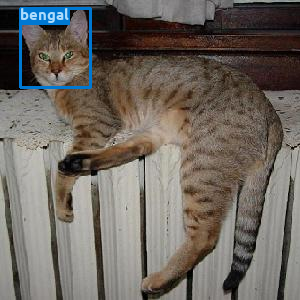

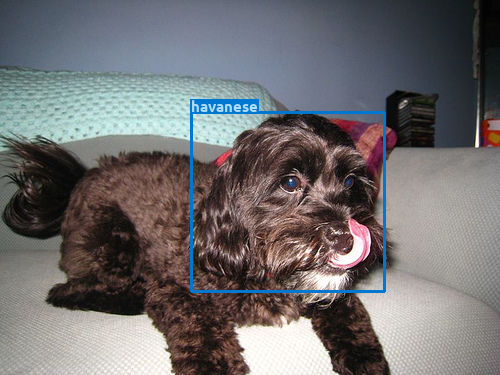

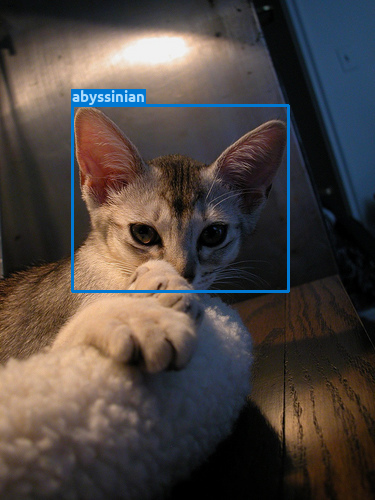

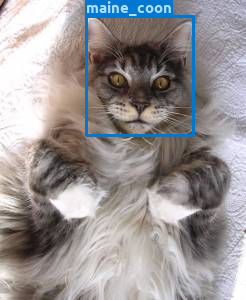

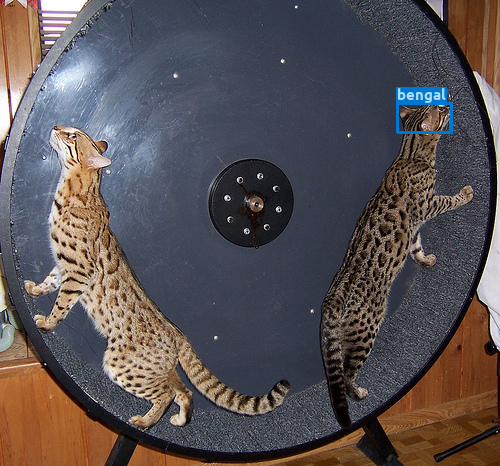

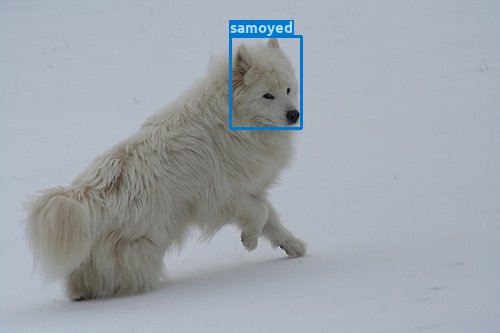

In [16]:
# View some Images from the Given Dataset
def view_image():
    'Display 5 random images from the dataset'
    n = np.random.randint(0, len(df)-5)
    for i in range(6):
        im = cv2.imread(df.filename[n+i])
        bb.add(im,df.xmin[n+i], df.ymin[n+i], df.xmax[n+i], df.ymax[n+i], label=f'{df["class"][n+i]}', color='blue')
        cv2_imshow(im)

view_image()